# Baran parameterizations comparison (v2c) - Test 1 - Broadband

For ranges used in Test 1 - Altitude/Temperature:

* Ice Mass Mixing ratio qi (kg/kg) range: (0.04 to 0.11) * 0.001

* Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

* Ice Water Path IWP (g/m2):
iwp = np.arange(0.1, 300.1, 0.1)

* Fized Effective Radius r_e (um) (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

Broadband optical property computed as:

$$\frac{\int_\lambda \text{OPT } d\lambda}{\int_\lambda d\lambda}$$

where OPT$(\lambda)$ can be any optical property ($K_{ext}$, $\omega$, $K_{abs}$ and $g$).

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

In [2]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

Reading Tropical Climatology

In [3]:
in_dir    = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/1-ecrad_inputs/')
file      = 'input_1Dset_test1_v7a.nc'
test1_in = xr.open_dataset(in_dir+file)

In [4]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_12228/2977779303.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/tropical_profile_ellingson_250m.txt',


In [5]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(test1_in.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(test1_in.pressure_hl.values)

In [6]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

Reading Optical Schemes LUT

in_dir    = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')

fu_sw = xr.open_dataset(in_dir+'FuSW_test1_LUT_v1a.nc')
fu_lw = xr.open_dataset(in_dir+'FuLW_test1_LUT_v1a.nc')
baran14_sw = xr.open_dataset(in_dir+'Baran14SW_test1_LUT_v1a.nc')
baran14_lw = xr.open_dataset(in_dir+'Baran14LW_test1_LUT_v1a.nc')
baran16_sw = xr.open_dataset(in_dir+'Baran16SW_test1_LUT_v1a.nc')
baran16_lw = xr.open_dataset(in_dir+'Baran16LW_test1_LUT_v1a.nc')

In [7]:
in_dir    = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')

fu_sw = xr.open_dataset(in_dir+'FuSW_LUT_v2a.nc')
fu_lw = xr.open_dataset(in_dir+'FuLW_LUT_v2a.nc')
baran14_sw = xr.open_dataset(in_dir+'Baran14SW_LUT_v2a.nc')
baran14_lw = xr.open_dataset(in_dir+'Baran14LW_LUT_v2a.nc')
baran16_sw = xr.open_dataset(in_dir+'Baran16SW_LUT_v2a.nc')
baran16_lw = xr.open_dataset(in_dir+'Baran16LW_LUT_v2a.nc')

Reading Fu optical scheme wavelength bands:

In [8]:
# This seems to be the one used in ecRad calculations:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_rad_data_backup/')
file      = 'fu_ice_scattering_rrtm.nc'
#fu_scatt  = xr.open_dataset(data_path+file, drop_variables='siglay')
fu_scatt = nc.Dataset(data_path+file)

In [9]:
fu_sw_wn1 = fu_scatt.variables['wavenumber1_sw'][:]
fu_sw_wn2 = fu_scatt.variables['wavenumber2_sw'][:]

fu_lw_wn1 = fu_scatt.variables['wavenumber1_lw'][:]
fu_lw_wn2 = fu_scatt.variables['wavenumber2_lw'][:]

## Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$:

Position of 30 um (Fixed Size):

# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

pos30 = np.where(r_e == 30)[0][0]

In [10]:
# Ice Mass Mixing ratio qi (kg/kg):
q_i = np.arange(0.1e-3, 0.7001, 0.1e-3) * 0.001 #np.arange(0.04, 0.11, 0.001) * 0.001 # Old Range used in Test 1 - Altitude/Temperature.

# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

# Effective Radius (um)
r_e  = np.arange(5, 60, 1)

pos30 = np.where(r_e == 30)[0][0]

In [11]:
fu_sw_K_ext = fu_sw.K_ext.values
fu_lw_K_ext = fu_lw.K_ext.values
baran14_sw_K_ext = baran14_sw.K_ext.values
baran14_lw_K_ext = baran14_lw.K_ext.values
baran16_sw_K_ext = baran16_sw.K_ext.values
baran16_lw_K_ext = baran16_lw.K_ext.values

I like to check the table in excel:

In [12]:
#np.savetxt('out_tables_to_check/fu_lw_Kext.csv', fu_lw_K_ext[:,pos30,0], delimiter = ",")
#np.savetxt('out_tables_to_check/b14_lw_Kext.csv', baran14_lw_K_ext, delimiter = ",")
#np.savetxt('out_tables_to_check/lw_wl1.csv', 1e4/eval('fu_lw_wn1'), delimiter = ",")
#np.savetxt('out_tables_to_check/lw_wl2.csv', 1e4/eval('fu_lw_wn2'), delimiter = ",")
#np.savetxt('out_tables_to_check/q_i.csv', q_i, delimiter = ",")

tempi = test1_in.sizes['column']     # Temperature Levels
profi = test1_in.sizes['half_level'] # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## K_ext Calculation Matrices:
K_ext_sw_t1_bb = np.zeros((3, tempi, profi))
K_ext_lw_t1_bb = np.zeros((3, tempi, profi))

## Matrices for plotting:
K_ext_sw_t1_bb_plot = np.zeros((3, profi, tempi))
K_ext_lw_t1_bb_plot = np.zeros((3, profi, tempi))

for sch in range(3): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = test1_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test1_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kext = 0
                K_ext_sw_t1_bb[sch, i, q_ix] = 0
                K_ext_lw_t1_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_K_ext  = 0
                b14_sw_bb_K_ext = 0
                b16_sw_bb_K_ext = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_K_ext  += fu_sw_K_ext[sw_band, pos30, min_i]*Dl
                    b14_sw_bb_K_ext += baran14_sw_K_ext[sw_band, min_i]*Dl
                    b16_sw_bb_K_ext += baran16_sw_K_ext[sw_band, min_Tdiff, min_i]*Dl
                K_ext_sw_t1_bb[0, i, q_ix] = fu_sw_bb_K_ext
                K_ext_sw_t1_bb[1, i, q_ix] = b14_sw_bb_K_ext 
                K_ext_sw_t1_bb[2, i, q_ix] = b16_sw_bb_K_ext
                
                fu_lw_bb_K_ext  = 0
                b14_lw_bb_K_ext = 0
                b16_lw_bb_K_ext = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_K_ext += fu_lw_K_ext[lw_band, pos30, min_i]*Dl
                    b14_lw_bb_K_ext += baran14_lw_K_ext[lw_band, min_i]*Dl
                    b16_lw_bb_K_ext += baran16_lw_K_ext[lw_band, min_Tdiff, min_i]*Dl
                K_ext_lw_t1_bb[0, i, q_ix] = fu_lw_bb_K_ext
                K_ext_lw_t1_bb[1, i, q_ix] = b14_lw_bb_K_ext 
                K_ext_lw_t1_bb[2, i, q_ix] = b16_lw_bb_K_ext
                
    # For plotting:
    K_ext_sw_t1_bb_plot[sch,:,:] = np.transpose(K_ext_sw_t1_bb[sch,:,:])
    K_ext_lw_t1_bb_plot[sch,:,:] = np.transpose(K_ext_lw_t1_bb[sch,:,:])

In [13]:
tempi = test1_in.sizes['column']     # Temperature Levels
profi = test1_in.sizes['half_level'] # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## K_ext Calculation Matrices:
K_ext_sw_t1_bb = np.zeros((3, tempi, profi))
K_ext_lw_t1_bb = np.zeros((3, tempi, profi))

## Matrices for plotting:
K_ext_sw_t1_bb_plot = np.zeros((3, profi, tempi))
K_ext_lw_t1_bb_plot = np.zeros((3, profi, tempi))

for sch in range(3): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = test1_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test1_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kext = 0
                K_ext_sw_t1_bb[sch, i, q_ix] = 0
                K_ext_lw_t1_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_K_ext  = 0
                b14_sw_bb_K_ext = 0
                b16_sw_bb_K_ext = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_K_ext  += fu_sw_K_ext[sw_band, pos30]*Dl
                    b14_sw_bb_K_ext += baran14_sw_K_ext[sw_band, min_qidiff]*Dl
                    b16_sw_bb_K_ext += baran16_sw_K_ext[sw_band, min_qidiff, min_Tdiff]*Dl
                K_ext_sw_t1_bb[0, i, q_ix] = fu_sw_bb_K_ext
                K_ext_sw_t1_bb[1, i, q_ix] = b14_sw_bb_K_ext 
                K_ext_sw_t1_bb[2, i, q_ix] = b16_sw_bb_K_ext
                
                fu_lw_bb_K_ext  = 0
                b14_lw_bb_K_ext = 0
                b16_lw_bb_K_ext = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_K_ext += fu_lw_K_ext[lw_band, pos30]*Dl
                    b14_lw_bb_K_ext += baran14_lw_K_ext[lw_band, min_qidiff]*Dl
                    b16_lw_bb_K_ext += baran16_lw_K_ext[lw_band, min_qidiff, min_Tdiff]*Dl
                K_ext_lw_t1_bb[0, i, q_ix] = fu_lw_bb_K_ext
                K_ext_lw_t1_bb[1, i, q_ix] = b14_lw_bb_K_ext 
                K_ext_lw_t1_bb[2, i, q_ix] = b16_lw_bb_K_ext
                
    # For plotting:
    K_ext_sw_t1_bb_plot[sch,:,:] = np.transpose(K_ext_sw_t1_bb[sch,:,:])
    K_ext_lw_t1_bb_plot[sch,:,:] = np.transpose(K_ext_lw_t1_bb[sch,:,:])

In [14]:
# Shortwave:
K_ext_sw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
K_ext_sw_t1_bb_diff_plot[0] = K_ext_sw_t1_bb_plot[1] - K_ext_sw_t1_bb_plot[0] # Baran2014 - Fu
K_ext_sw_t1_bb_diff_plot[1] = K_ext_sw_t1_bb_plot[2] - K_ext_sw_t1_bb_plot[0] # Baran2016 - Fu

# Longwave:
K_ext_lw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
K_ext_lw_t1_bb_diff_plot[0] = K_ext_lw_t1_bb_plot[1] - K_ext_lw_t1_bb_plot[0] # Baran2014 - Fu
K_ext_lw_t1_bb_diff_plot[1] = K_ext_lw_t1_bb_plot[2] - K_ext_lw_t1_bb_plot[0] # Baran2016 - Fu

This next cell is to take 0s out from the matrix visualization. The colorbar will focus on the small differences within the cloud layer:

In [15]:
K_ext_sw_t1_bb_diff_plot[K_ext_sw_t1_bb_diff_plot == 0] = np.nan
K_ext_lw_t1_bb_diff_plot[K_ext_lw_t1_bb_diff_plot == 0] = np.nan

### Figure with absolute values:

Now, we can study the difference range to show in the figures:

In [16]:
# Shortwave K_ext differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(K_ext_sw_t1_bb_diff_plot[0][np.nonzero(K_ext_sw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(K_ext_sw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(K_ext_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(K_ext_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave K_ext differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(K_ext_lw_t1_bb_diff_plot[0][np.nonzero(K_ext_lw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(K_ext_lw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(K_ext_lw_t1_bb_diff_plot[1][np.nonzero(K_ext_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(K_ext_lw_t1_bb_diff_plot[1][np.nonzero(K_ext_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  -0.014567780855062024
Baran2014 - Fu min:  -0.014601266657435913
Baran2016 - Fu max:  0.19942938069531668
Baran2016 - Fu min:  -0.018392076240174193

Longwave CRH Differences:
Baran2014 - Fu max:  -0.1413400721507112
Baran2014 - Fu min:  -0.14364148854794823
Baran2016 - Fu max:  1.4471278163175092
Baran2016 - Fu min:  -0.14003118747128473


<IPython.core.display.Javascript object>


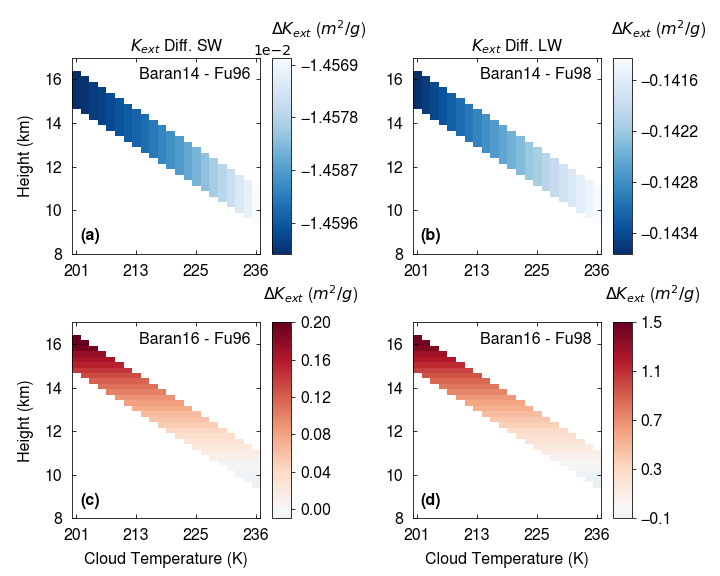

In [17]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -14.560e-3
        vmaxi_sw   = -14.605e-3
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'Blues_r'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -14.4e-2
        vmaxi_lw   = -14.1e-2
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Blues_r'
        norm_lw    = None
        
        labelpad   = -40
    else:
        # For SW:
        vmini_sw   = -0.01
        vmaxi_sw   = 0.2
        tickbar_sw = np.linspace(0, vmaxi_sw, 6)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = -0.1
        vmaxi_lw   = 1.5
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -20
         
    # Shortwave K_ext Difference
    im = ax[schi, 0].imshow(K_ext_sw_t1_bb_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$K_{ext}$ Diff. SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_ext Difference
    im = ax[schi, 1].imshow(K_ext_lw_t1_bb_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$K_{ext}$ Diff. LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_ext_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_diff_SM_v2c.png', dpi=500)

### Figure with relative difference:

In [18]:
# Shortwave:
K_ext_sw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
K_ext_sw_t1_bb_diff_plot_RD[0] = ((K_ext_sw_t1_bb_plot[1] - K_ext_sw_t1_bb_plot[0])/K_ext_sw_t1_bb_plot[0])*100
# Baran2016 - Fu
K_ext_sw_t1_bb_diff_plot_RD[1] = ((K_ext_sw_t1_bb_plot[2] - K_ext_sw_t1_bb_plot[0])/K_ext_sw_t1_bb_plot[0])*100

# Longwave:
K_ext_lw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
K_ext_lw_t1_bb_diff_plot_RD[0] = ((K_ext_lw_t1_bb_plot[1] - K_ext_lw_t1_bb_plot[0])/K_ext_lw_t1_bb_plot[0])*100
# Baran2016 - Fu
K_ext_lw_t1_bb_diff_plot_RD[1] = ((K_ext_lw_t1_bb_plot[2] - K_ext_lw_t1_bb_plot[0])/K_ext_lw_t1_bb_plot[0])*100

/tmp/ipykernel_18978/1964812883.py:4: RuntimeWarning: invalid value encountered in divide
  K_ext_sw_t1_bb_diff_plot_RD[0] = ((K_ext_sw_t1_bb_plot[1] - K_ext_sw_t1_bb_plot[0])/K_ext_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/1964812883.py:6: RuntimeWarning: invalid value encountered in divide
  K_ext_sw_t1_bb_diff_plot_RD[1] = ((K_ext_sw_t1_bb_plot[2] - K_ext_sw_t1_bb_plot[0])/K_ext_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/1964812883.py:11: RuntimeWarning: invalid value encountered in divide
  K_ext_lw_t1_bb_diff_plot_RD[0] = ((K_ext_lw_t1_bb_plot[1] - K_ext_lw_t1_bb_plot[0])/K_ext_lw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/1964812883.py:13: RuntimeWarning: invalid value encountered in divide
  K_ext_lw_t1_bb_diff_plot_RD[1] = ((K_ext_lw_t1_bb_plot[2] - K_ext_lw_t1_bb_plot[0])/K_ext_lw_t1_bb_plot[0])*100


In [19]:
# Shortwave K_ext differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(K_ext_sw_t1_bb_diff_plot_RD[0][np.nonzero(K_ext_sw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(K_ext_sw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(K_ext_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(K_ext_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave K_ext differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(K_ext_lw_t1_bb_diff_plot_RD[0][np.nonzero(K_ext_lw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(K_ext_lw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(K_ext_lw_t1_bb_diff_plot_RD[1][np.nonzero(K_ext_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(K_ext_lw_t1_bb_diff_plot_RD[1][np.nonzero(K_ext_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  -7.324894990825703
Baran2014 - Fu min:  -7.341732145949921
Baran2016 - Fu max:  100.27603285719373
Baran2016 - Fu min:  -9.247807093125221

Longwave CRH Differences:
Baran2014 - Fu max:  -9.713013865021134
Baran2014 - Fu min:  -9.87116922064961
Baran2016 - Fu max:  99.4478942204148
Baran2016 - Fu min:  -9.623066160555362


<IPython.core.display.Javascript object>


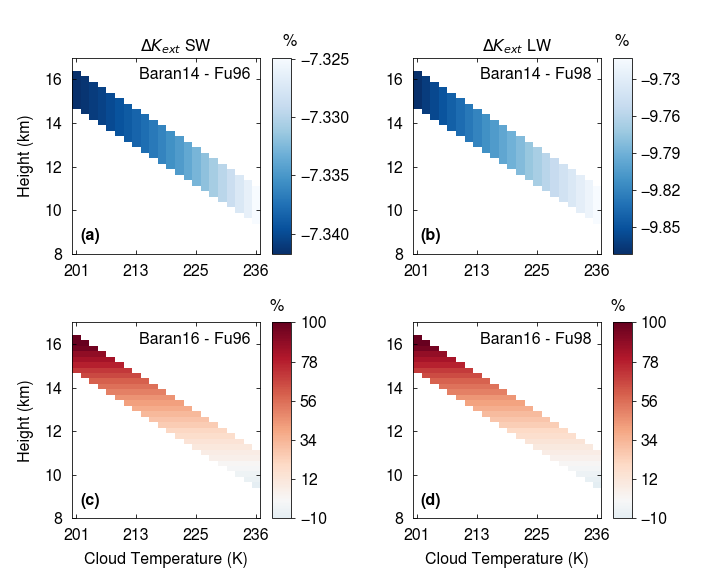

In [20]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -7.35
        vmaxi_sw   = -7.32
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'Blues_r'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -9.88
        vmaxi_lw   = -9.7
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 7)
        cmap_lw    = 'Blues_r'
        norm_lw    = None
        
        labelpad   = -60
    else:
        # For SW:
        vmini_sw   = -10
        vmaxi_sw   = 100
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = -10
        vmaxi_lw   = 100
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -50
         
    # Shortwave K_ext Difference
    im = ax[schi, 0].imshow(K_ext_sw_t1_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta K_{ext}$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_ext Difference
    im = ax[schi, 1].imshow(K_ext_lw_t1_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta K_{ext}$ LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_ext_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm):

In [21]:
K_ext_sw_t1_bb_RD_colorbar = [[np.linspace(-7.35, -7.32, 7), 'Blues_r', None],
                             [np.linspace(-10, 100, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -10, vmax = 100)]]
K_ext_lw_t1_bb_RD_colorbar = [[np.linspace(-9.88, -9.7, 7), 'Blues_r', None],
                             [np.linspace(-10, 100, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -10, vmax = 100)]]

## Single Scatter Albedo $\omega_0$

Position of 30 um (Fixed Size). Already defined for Extinction Coefficient:

In [22]:
fu_sw_ssa = fu_sw.ssa.values
fu_lw_ssa = fu_lw.ssa.values
baran14_sw_ssa = baran14_sw.ssa.values
baran14_lw_ssa = baran14_lw.ssa.values
baran16_sw_ssa = baran16_sw.ssa.values
baran16_lw_ssa = baran16_lw.ssa.values

I like to check the table in excel:

In [23]:
#np.savetxt('out_tables_to_check/fu_lw_ssa.csv', fu_lw_ssa[:,pos30,0], delimiter = ",")
#np.savetxt('out_tables_to_check/b14_lw_ssa.csv', baran14_lw_ssa, delimiter = ",")

In [24]:
tempi = test1_in.sizes['column']     # Temperature Levels
profi = test1_in.sizes['half_level'] # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## ssa Calculation Matrices:
ssa_sw_t1_bb = np.zeros((3, tempi, profi))
ssa_lw_t1_bb = np.zeros((3, tempi, profi))

## Matrices for plotting:
ssa_sw_t1_bb_plot = np.zeros((3, profi, tempi))
ssa_lw_t1_bb_plot = np.zeros((3, profi, tempi))

for sch in range(3): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = test1_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test1_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, ssa = 0
                ssa_sw_t1_bb[sch, i, q_ix] = 0
                ssa_lw_t1_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_ssa  = 0
                b14_sw_bb_ssa = 0
                b16_sw_bb_ssa = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_ssa += fu_sw_ssa[sw_band, pos30]*Dl
                    b14_sw_bb_ssa += baran14_sw_ssa[sw_band, min_qidiff]*Dl
                    b16_sw_bb_ssa += baran16_sw_ssa[sw_band, min_qidiff, min_Tdiff]*Dl
                ssa_sw_t1_bb[0, i, q_ix] = fu_sw_bb_ssa
                ssa_sw_t1_bb[1, i, q_ix] = b14_sw_bb_ssa 
                ssa_sw_t1_bb[2, i, q_ix] = b16_sw_bb_ssa
                
                fu_lw_bb_ssa  = 0
                b14_lw_bb_ssa = 0
                b16_lw_bb_ssa = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_ssa += fu_lw_ssa[lw_band, pos30]*Dl
                    b14_lw_bb_ssa += baran14_lw_ssa[lw_band, min_qidiff]*Dl
                    b16_lw_bb_ssa += baran16_lw_ssa[lw_band, min_qidiff, min_Tdiff]*Dl
                ssa_lw_t1_bb[0, i, q_ix] = fu_lw_bb_ssa
                ssa_lw_t1_bb[1, i, q_ix] = b14_lw_bb_ssa 
                ssa_lw_t1_bb[2, i, q_ix] = b16_lw_bb_ssa
                
    # For plotting:
    ssa_sw_t1_bb_plot[sch,:,:] = np.transpose(ssa_sw_t1_bb[sch,:,:])
    ssa_lw_t1_bb_plot[sch,:,:] = np.transpose(ssa_lw_t1_bb[sch,:,:])

Interscheme Difference:

In [25]:
# Shortwave:
ssa_sw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
ssa_sw_t1_bb_diff_plot[0] = ssa_sw_t1_bb_plot[1] - ssa_sw_t1_bb_plot[0] # Baran2014 - Fu
ssa_sw_t1_bb_diff_plot[1] = ssa_sw_t1_bb_plot[2] - ssa_sw_t1_bb_plot[0] # Baran2016 - Fu

# Longwave:
ssa_lw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
ssa_lw_t1_bb_diff_plot[0] = ssa_lw_t1_bb_plot[1] - ssa_lw_t1_bb_plot[0] # Baran2014 - Fu
ssa_lw_t1_bb_diff_plot[1] = ssa_lw_t1_bb_plot[2] - ssa_lw_t1_bb_plot[0] # Baran2016 - Fu

This next cell is to take 0s out from the matrix visualization. The colorbar will focus on the small differences within the cloud layer:

In [26]:
ssa_sw_t1_bb_diff_plot[ssa_sw_t1_bb_diff_plot == 0] = np.nan
ssa_lw_t1_bb_diff_plot[ssa_lw_t1_bb_diff_plot == 0] = np.nan

### Figure with absolute values

Now, we can study the difference range to show in the figures:

In [27]:
# Shortwave ssa differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(ssa_sw_t1_bb_diff_plot[0][np.nonzero(ssa_sw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(ssa_sw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(ssa_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(ssa_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave ssa differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(ssa_lw_t1_bb_diff_plot[0][np.nonzero(ssa_lw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(ssa_lw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(ssa_lw_t1_bb_diff_plot[1][np.nonzero(ssa_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(ssa_lw_t1_bb_diff_plot[1][np.nonzero(ssa_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  0.09993016622896089
Baran2014 - Fu min:  0.04724168908965343
Baran2016 - Fu max:  0.2557263594929653
Baran2016 - Fu min:  0.24882813016675964

Longwave CRH Differences:
Baran2014 - Fu max:  0.1513164347591207
Baran2014 - Fu min:  -0.3577355798480859
Baran2016 - Fu max:  0.7126855889717305
Baran2016 - Fu min:  0.6852575644839298


In [28]:
#np.savetxt('out_tables_to_check/b14_fu_lw_ssa.csv', ssa_lw_t1_bb_diff_plot[0], delimiter = ",")

<IPython.core.display.Javascript object>


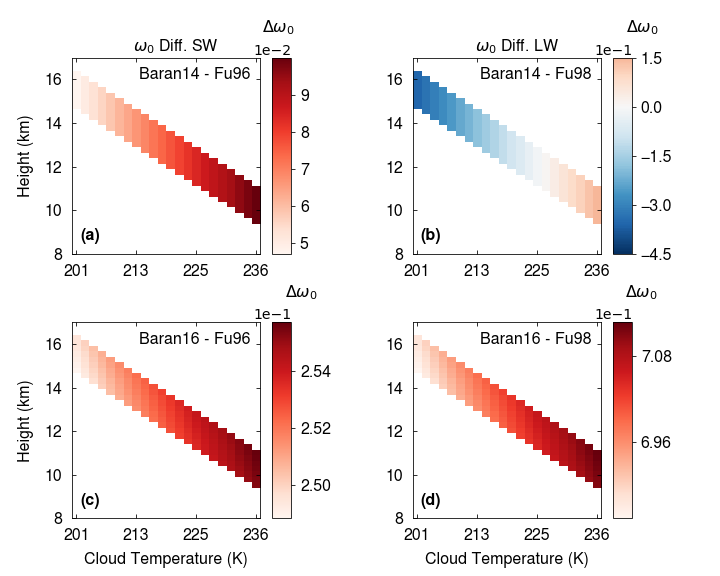

In [29]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = 0.04
        vmaxi_sw   = 0.1
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'Reds'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -0.45
        vmaxi_lw   = 0.15
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -30
    else:
        # For SW:
        vmini_sw   = 0.244
        vmaxi_sw   = 0.256
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'Reds'
        norm_sw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = 0.66
        vmaxi_lw   = 0.72
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Reds'
        norm_lw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -30
         
    # Shortwave ssa Difference
    im = ax[schi, 0].imshow(ssa_sw_t1_bb_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta \omega_0$', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\omega_0$ Diff. SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave ssa Difference
    im = ax[schi, 1].imshow(ssa_lw_t1_bb_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta \omega_0$', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\omega_0$ Diff. LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, ssa_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_diff_SM_v2c.png', dpi=500)

### Figure with relative difference

In [30]:
# Shortwave:
ssa_sw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
ssa_sw_t1_bb_diff_plot_RD[0] = ((ssa_sw_t1_bb_plot[1] - ssa_sw_t1_bb_plot[0])/ssa_sw_t1_bb_plot[0])*100
# Baran2016 - Fu
ssa_sw_t1_bb_diff_plot_RD[1] = ((ssa_sw_t1_bb_plot[2] - ssa_sw_t1_bb_plot[0])/ssa_sw_t1_bb_plot[0])*100

# Longwave:
ssa_lw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
ssa_lw_t1_bb_diff_plot_RD[0] = ((ssa_lw_t1_bb_plot[1] - ssa_lw_t1_bb_plot[0])/ssa_lw_t1_bb_plot[0])*100
# Baran2016 - Fu
ssa_lw_t1_bb_diff_plot_RD[1] = ((ssa_lw_t1_bb_plot[2] - ssa_lw_t1_bb_plot[0])/ssa_lw_t1_bb_plot[0])*100

/tmp/ipykernel_18978/2853390541.py:4: RuntimeWarning: invalid value encountered in divide
  ssa_sw_t1_bb_diff_plot_RD[0] = ((ssa_sw_t1_bb_plot[1] - ssa_sw_t1_bb_plot[0])/ssa_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/2853390541.py:6: RuntimeWarning: invalid value encountered in divide
  ssa_sw_t1_bb_diff_plot_RD[1] = ((ssa_sw_t1_bb_plot[2] - ssa_sw_t1_bb_plot[0])/ssa_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/2853390541.py:11: RuntimeWarning: invalid value encountered in divide
  ssa_lw_t1_bb_diff_plot_RD[0] = ((ssa_lw_t1_bb_plot[1] - ssa_lw_t1_bb_plot[0])/ssa_lw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/2853390541.py:13: RuntimeWarning: invalid value encountered in divide
  ssa_lw_t1_bb_diff_plot_RD[1] = ((ssa_lw_t1_bb_plot[2] - ssa_lw_t1_bb_plot[0])/ssa_lw_t1_bb_plot[0])*100


In [31]:
# Shortwave ssa differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(ssa_sw_t1_bb_diff_plot_RD[0][np.nonzero(ssa_sw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(ssa_sw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(ssa_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(ssa_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave ssa differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(ssa_lw_t1_bb_diff_plot_RD[0][np.nonzero(ssa_lw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(ssa_lw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(ssa_lw_t1_bb_diff_plot_RD[1][np.nonzero(ssa_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(ssa_lw_t1_bb_diff_plot_RD[1][np.nonzero(ssa_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  3.307777479785424
Baran2014 - Fu min:  1.563741972766708
Baran2016 - Fu max:  8.464770197422073
Baran2016 - Fu min:  8.236432664555991

Longwave CRH Differences:
Baran2014 - Fu max:  0.9727682171270844
Baran2014 - Fu min:  -2.299775320279747
Baran2016 - Fu max:  4.581643037385987
Baran2016 - Fu min:  4.405316450503411


<IPython.core.display.Javascript object>


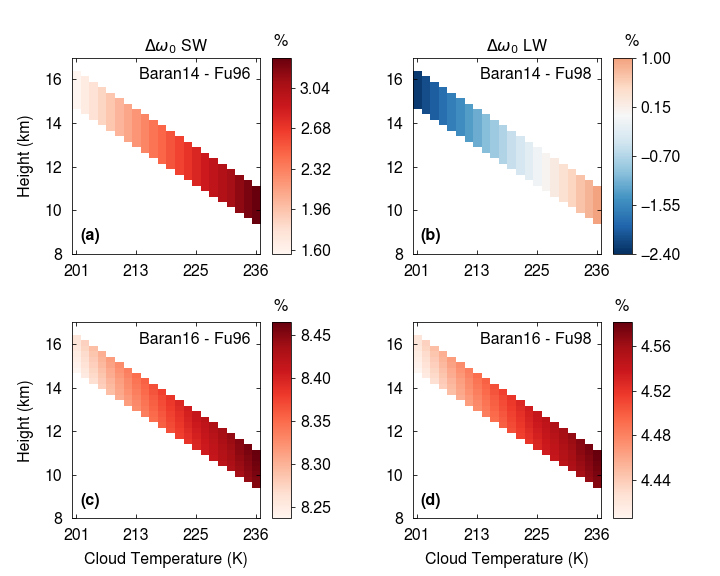

In [32]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = 1.6
        vmaxi_sw   = 3.4
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'Reds'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -2.4
        vmaxi_lw   = 1
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)
        
        labelpad   = -50
    else:
        # For SW:
        vmini_sw   = 8.2
        vmaxi_sw   = 8.5
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'Reds'
        norm_sw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = 4.4
        vmaxi_lw   = 4.6
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Reds'
        norm_lw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -50
         
    # Shortwave ssa Difference
    im = ax[schi, 0].imshow(ssa_sw_t1_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta \omega_0$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave ssa Difference
    im = ax[schi, 1].imshow(ssa_lw_t1_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta \omega_0$ LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, ssa_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_ssa_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm):

In [33]:
ssa_sw_t1_bb_RD_colorbar = [[np.linspace(1.6, 3.4, 6), 'Reds', None],
                             [np.linspace(8.2, 8.5, 7), 'Reds', None]]
ssa_lw_t1_bb_RD_colorbar = [[np.linspace(-2.4, 1, 5), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -2.4, vmax = 1)],
                             [np.linspace(4.4, 4.6, 6), 'Reds', None]]

## Mass Absorption Coefficient $K_{abs}$ $(m^2/g)$:

Position of 30 um (Fixed Size). Already defined for Extinction Coefficient:

In [34]:
fu_sw_K_abs = fu_sw.K_abs.values
fu_lw_K_abs = fu_lw.K_abs.values
baran14_sw_K_abs = baran14_sw.K_abs.values
baran14_lw_K_abs = baran14_lw.K_abs.values
baran16_sw_K_abs = baran16_sw.K_abs.values
baran16_lw_K_abs = baran16_lw.K_abs.values

I like to check the table in excel:

In [35]:
#np.savetxt('out_tables_to_check/fu_lw_Kext.csv', fu_lw_K_ext[:,pos30,0], delimiter = ",")
#np.savetxt('out_tables_to_check/b14_lw_Kext.csv', baran14_lw_K_ext, delimiter = ",")
#np.savetxt('out_tables_to_check/lw_wl1.csv', 1e4/eval('fu_lw_wn1'), delimiter = ",")
#np.savetxt('out_tables_to_check/lw_wl2.csv', 1e4/eval('fu_lw_wn2'), delimiter = ",")
#np.savetxt('out_tables_to_check/q_i.csv', q_i, delimiter = ",")

In [36]:
tempi = test1_in.sizes['column']     # Temperature Levels
profi = test1_in.sizes['half_level'] # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## K_abs Calculation Matrices:
K_abs_sw_t1_bb = np.zeros((3, tempi, profi))
K_abs_lw_t1_bb = np.zeros((3, tempi, profi))

## Matrices for plotting:
K_abs_sw_t1_bb_plot = np.zeros((3, profi, tempi))
K_abs_lw_t1_bb_plot = np.zeros((3, profi, tempi))

for sch in range(3): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = test1_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test1_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, Kabs = 0
                K_abs_sw_t1_bb[sch, i, q_ix] = 0
                K_abs_lw_t1_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_K_abs  = 0
                b14_sw_bb_K_abs = 0
                b16_sw_bb_K_abs = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_K_abs  += fu_sw_K_abs[sw_band, pos30]*Dl
                    b14_sw_bb_K_abs += baran14_sw_K_abs[sw_band, min_qidiff]*Dl
                    b16_sw_bb_K_abs += baran16_sw_K_abs[sw_band, min_qidiff, min_Tdiff]*Dl
                K_abs_sw_t1_bb[0, i, q_ix] = fu_sw_bb_K_abs
                K_abs_sw_t1_bb[1, i, q_ix] = b14_sw_bb_K_abs 
                K_abs_sw_t1_bb[2, i, q_ix] = b16_sw_bb_K_abs
                
                fu_lw_bb_K_abs  = 0
                b14_lw_bb_K_abs = 0
                b16_lw_bb_K_abs = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_K_abs += fu_lw_K_abs[lw_band, pos30]*Dl
                    b14_lw_bb_K_abs += baran14_lw_K_abs[lw_band, min_qidiff]*Dl
                    b16_lw_bb_K_abs += baran16_lw_K_abs[lw_band, min_qidiff, min_Tdiff]*Dl
                K_abs_lw_t1_bb[0, i, q_ix] = fu_lw_bb_K_abs
                K_abs_lw_t1_bb[1, i, q_ix] = b14_lw_bb_K_abs 
                K_abs_lw_t1_bb[2, i, q_ix] = b16_lw_bb_K_abs
                
    # For plotting:
    K_abs_sw_t1_bb_plot[sch,:,:] = np.transpose(K_abs_sw_t1_bb[sch,:,:])
    K_abs_lw_t1_bb_plot[sch,:,:] = np.transpose(K_abs_lw_t1_bb[sch,:,:])

In [37]:
# Shortwave:
K_abs_sw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
K_abs_sw_t1_bb_diff_plot[0] = K_abs_sw_t1_bb_plot[1] - K_abs_sw_t1_bb_plot[0] # Baran2014 - Fu
K_abs_sw_t1_bb_diff_plot[1] = K_abs_sw_t1_bb_plot[2] - K_abs_sw_t1_bb_plot[0] # Baran2016 - Fu

# Longwave:
K_abs_lw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
K_abs_lw_t1_bb_diff_plot[0] = K_abs_lw_t1_bb_plot[1] - K_abs_lw_t1_bb_plot[0] # Baran2014 - Fu
K_abs_lw_t1_bb_diff_plot[1] = K_abs_lw_t1_bb_plot[2] - K_abs_lw_t1_bb_plot[0] # Baran2016 - Fu

This next cell is to take 0s out from the matrix visualization. The colorbar will focus on the small differences within the cloud layer:

In [38]:
K_abs_sw_t1_bb_diff_plot[K_abs_sw_t1_bb_diff_plot == 0] = np.nan
K_abs_lw_t1_bb_diff_plot[K_abs_lw_t1_bb_diff_plot == 0] = np.nan

### Figure with absolute values

Now, we can study the difference range to show in the figures:

In [39]:
# Shortwave K_abs differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(K_abs_sw_t1_bb_diff_plot[0][np.nonzero(K_abs_sw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(K_abs_sw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(K_abs_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(K_abs_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave K_abs differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(K_abs_lw_t1_bb_diff_plot[0][np.nonzero(K_abs_lw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(K_abs_lw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(K_abs_lw_t1_bb_diff_plot[1][np.nonzero(K_abs_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(K_abs_lw_t1_bb_diff_plot[1][np.nonzero(K_abs_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  -0.004783725399223365
Baran2014 - Fu min:  -0.007452631703122797
Baran2016 - Fu max:  0.0063923154390984685
Baran2016 - Fu min:  -0.016002184956929934

Longwave CRH Differences:
Baran2014 - Fu max:  -0.037409199544155114
Baran2014 - Fu min:  -0.0628344964404054
Baran2016 - Fu max:  0.48147849305449664
Baran2016 - Fu min:  -0.09272816878682877


<IPython.core.display.Javascript object>


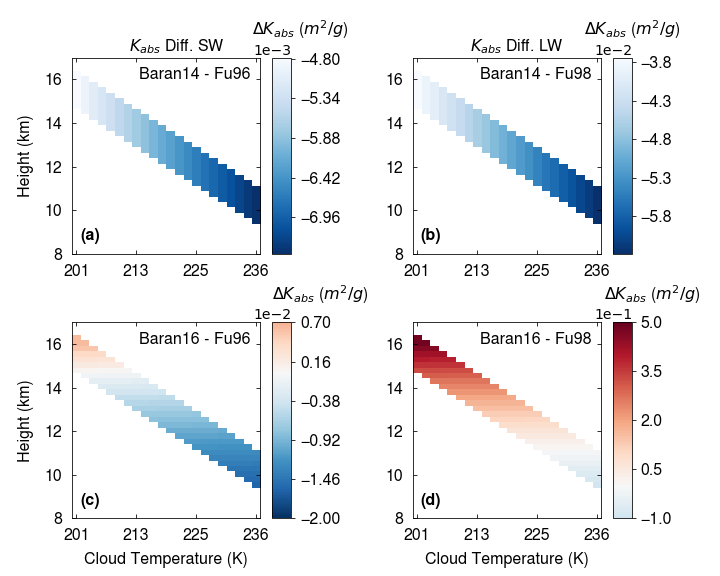

In [40]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -7.5e-3
        vmaxi_sw   = -4.8e-3
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'Blues_r'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -6.3e-2
        vmaxi_lw   = -3.8e-2
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Blues_r'
        norm_lw    = None
        
        labelpad   = -40
    else:
        # For SW:
        vmini_sw   = -0.02
        vmaxi_sw   = 0.007
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = -0.1
        vmaxi_lw   = 0.5
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -20
         
    # Shortwave K_abs Difference
    im = ax[schi, 0].imshow(K_abs_sw_t1_bb_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta K_{abs}$ ($m^{2}/g$)', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$K_{abs}$ Diff. SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_abs Difference
    im = ax[schi, 1].imshow(K_abs_lw_t1_bb_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta K_{abs}$ ($m^{2}/g$)', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$K_{abs}$ Diff. LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_abs_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kabs_barans_diff_SM_v2c.png', dpi=500)

### Figure with relative difference

In [41]:
# Shortwave:
K_abs_sw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
K_abs_sw_t1_bb_diff_plot_RD[0] = ((K_abs_sw_t1_bb_plot[1] - K_abs_sw_t1_bb_plot[0])/K_abs_sw_t1_bb_plot[0])*100
# Baran2016 - Fu
K_abs_sw_t1_bb_diff_plot_RD[1] = ((K_abs_sw_t1_bb_plot[2] - K_abs_sw_t1_bb_plot[0])/K_abs_sw_t1_bb_plot[0])*100

# Longwave:
K_abs_lw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
K_abs_lw_t1_bb_diff_plot_RD[0] = ((K_abs_lw_t1_bb_plot[1] - K_abs_lw_t1_bb_plot[0])/K_abs_lw_t1_bb_plot[0])*100
# Baran2016 - Fu
K_abs_lw_t1_bb_diff_plot_RD[1] = ((K_abs_lw_t1_bb_plot[2] - K_abs_lw_t1_bb_plot[0])/K_abs_lw_t1_bb_plot[0])*100

/tmp/ipykernel_18978/1199325169.py:4: RuntimeWarning: invalid value encountered in divide
  K_abs_sw_t1_bb_diff_plot_RD[0] = ((K_abs_sw_t1_bb_plot[1] - K_abs_sw_t1_bb_plot[0])/K_abs_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/1199325169.py:6: RuntimeWarning: invalid value encountered in divide
  K_abs_sw_t1_bb_diff_plot_RD[1] = ((K_abs_sw_t1_bb_plot[2] - K_abs_sw_t1_bb_plot[0])/K_abs_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/1199325169.py:11: RuntimeWarning: invalid value encountered in divide
  K_abs_lw_t1_bb_diff_plot_RD[0] = ((K_abs_lw_t1_bb_plot[1] - K_abs_lw_t1_bb_plot[0])/K_abs_lw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/1199325169.py:13: RuntimeWarning: invalid value encountered in divide
  K_abs_lw_t1_bb_diff_plot_RD[1] = ((K_abs_lw_t1_bb_plot[2] - K_abs_lw_t1_bb_plot[0])/K_abs_lw_t1_bb_plot[0])*100


In [42]:
# Shortwave K_abs differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(K_abs_sw_t1_bb_diff_plot_RD[0][np.nonzero(K_abs_sw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(K_abs_sw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(K_abs_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(K_abs_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave K_abs differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(K_abs_lw_t1_bb_diff_plot_RD[0][np.nonzero(K_abs_lw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(K_abs_lw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(K_abs_lw_t1_bb_diff_plot_RD[1][np.nonzero(K_abs_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(K_abs_lw_t1_bb_diff_plot_RD[1][np.nonzero(K_abs_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  -14.057827423375398
Baran2014 - Fu min:  -21.90088301253361
Baran2016 - Fu max:  18.784955192706807
Baran2016 - Fu min:  -47.025264986568075

Longwave CRH Differences:
Baran2014 - Fu max:  -6.606010499321487
Baran2014 - Fu min:  -11.095809273196554
Baran2016 - Fu max:  85.02325682112713
Baran2016 - Fu min:  -16.374668906390806


<IPython.core.display.Javascript object>


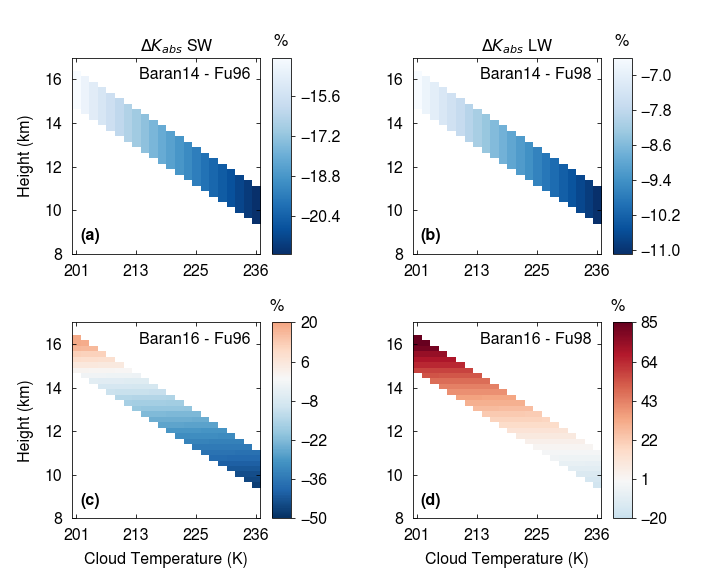

In [43]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -22
        vmaxi_sw   = -14
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'Blues_r'
        norm_sw    = None
        
        #For LW:
        vmini_lw   = -11
        vmaxi_lw   = -7
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Blues_r'
        norm_lw    = None
        
        labelpad   = -60
    else:
        # For SW:
        vmini_sw   = -50
        vmaxi_sw   = 20
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = -20
        vmaxi_lw   = 85
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'RdBu_r'
        norm_lw    = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -50
         
    # Shortwave K_abs Difference
    im = ax[schi, 0].imshow(K_abs_sw_t1_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta K_{abs}$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave K_abs Difference
    im = ax[schi, 1].imshow(K_abs_lw_t1_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta K_{abs}$ LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_abs_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm, labelpad):

In [44]:
K_abs_sw_t1_bb_RD_colorbar = [[np.linspace(-22, -14, 6), 'Blues_r', None],
                             [np.linspace(-50, 20, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -50, vmax = 20)]]
K_abs_lw_t1_bb_RD_colorbar = [[np.linspace(-11, -7, 6), 'Blues_r', None],
                             [np.linspace(-20, 85, 6), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -20, vmax = 85)]]

## Asymmetry Parameter g:

Position of 30 um (Fixed Size). Already defined for Extinction Coefficient:

In [45]:
fu_sw_g = fu_sw.g.values
fu_lw_g = fu_lw.g.values
baran14_sw_g = baran14_sw.g.values
baran14_lw_g = baran14_lw.g.values
baran16_sw_g = baran16_sw.g.values
baran16_lw_g = baran16_lw.g.values

I like to check the table in excel:

In [46]:
#np.savetxt('out_tables_to_check/fu_lw_g.csv', fu_lw_g[:,pos30,0], delimiter = ",")
#np.savetxt('out_tables_to_check/b14_lw_g.csv', baran14_lw_g, delimiter = ",")

In [47]:
tempi = test1_in.sizes['column']     # Temperature Levels
profi = test1_in.sizes['half_level'] # Vertical Profile

sw_bands = list(np.arange(0,13)[::-1])
lw_bands = list(np.arange(1,16)[::-1])

## g Calculation Matrices:
g_sw_t1_bb = np.zeros((3, tempi, profi))
g_lw_t1_bb = np.zeros((3, tempi, profi))

## Matrices for plotting:
g_sw_t1_bb_plot = np.zeros((3, profi, tempi))
g_lw_t1_bb_plot = np.zeros((3, profi, tempi))

for sch in range(3): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = test1_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = test1_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: # If there is no Ice cloud, g = 0
                g_sw_t1_bb[sch, i, q_ix] = 0
                g_lw_t1_bb[sch, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_qidiff   = q_difference.argmin()
                #print(sch, i, min_i)
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                fu_sw_bb_g  = 0
                b14_sw_bb_g = 0
                b16_sw_bb_g = 0
                for sw_band in sw_bands:
                    Dl = 1e4/fu_sw_wn1[sw_band] - 1e4/fu_sw_wn2[sw_band]
                    fu_sw_bb_g += fu_sw_g[sw_band, pos30]*Dl
                    b14_sw_bb_g += baran14_sw_g[sw_band, min_qidiff]*Dl
                    b16_sw_bb_g += baran16_sw_g[sw_band, min_qidiff, min_Tdiff]*Dl
                g_sw_t1_bb[0, i, q_ix] = fu_sw_bb_g
                g_sw_t1_bb[1, i, q_ix] = b14_sw_bb_g 
                g_sw_t1_bb[2, i, q_ix] = b16_sw_bb_g
                
                fu_lw_bb_g  = 0
                b14_lw_bb_g = 0
                b16_lw_bb_g = 0
                for lw_band in lw_bands:
                    Dl = 1e4/fu_lw_wn1[lw_band] - 1e4/fu_lw_wn2[lw_band]
                    fu_lw_bb_g += fu_lw_g[lw_band, pos30]*Dl
                    b14_lw_bb_g += baran14_lw_g[lw_band, min_qidiff]*Dl
                    b16_lw_bb_g += baran16_lw_g[lw_band, min_qidiff, min_Tdiff]*Dl
                g_lw_t1_bb[0, i, q_ix] = fu_lw_bb_g
                g_lw_t1_bb[1, i, q_ix] = b14_lw_bb_g 
                g_lw_t1_bb[2, i, q_ix] = b16_lw_bb_g
                
    # For plotting:
    g_sw_t1_bb_plot[sch,:,:] = np.transpose(g_sw_t1_bb[sch,:,:])
    g_lw_t1_bb_plot[sch,:,:] = np.transpose(g_lw_t1_bb[sch,:,:])

Interscheme Difference:

In [48]:
# Shortwave:
g_sw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
g_sw_t1_bb_diff_plot[0] = g_sw_t1_bb_plot[1] - g_sw_t1_bb_plot[0] # Baran2014 - Fu
g_sw_t1_bb_diff_plot[1] = g_sw_t1_bb_plot[2] - g_sw_t1_bb_plot[0] # Baran2016 - Fu

# Longwave:
g_lw_t1_bb_diff_plot    = np.zeros((2, profi, tempi))
g_lw_t1_bb_diff_plot[0] = g_lw_t1_bb_plot[1] - g_lw_t1_bb_plot[0] # Baran2014 - Fu
g_lw_t1_bb_diff_plot[1] = g_lw_t1_bb_plot[2] - g_lw_t1_bb_plot[0] # Baran2016 - Fu

This next cell is to take 0s out from the matrix visualization. The colorbar will focus on the small differences within the cloud layer:

In [49]:
g_sw_t1_bb_diff_plot[g_sw_t1_bb_diff_plot == 0] = np.nan
g_lw_t1_bb_diff_plot[g_lw_t1_bb_diff_plot == 0] = np.nan

### Figure with absolute values

Now, we can study the difference range to show in the figures:

In [50]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(g_sw_t1_bb_diff_plot[0][np.nonzero(g_sw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(g_sw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(g_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(g_sw_t1_bb_diff_plot[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave g differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(g_lw_t1_bb_diff_plot[0][np.nonzero(g_lw_t1_bb_diff_plot[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(g_lw_t1_bb_diff_plot[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(g_lw_t1_bb_diff_plot[1][np.nonzero(g_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(g_lw_t1_bb_diff_plot[1][np.nonzero(g_lw_t1_bb_diff_plot[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  0.01455499440711483
Baran2014 - Fu min:  -0.012028376044191713
Baran2016 - Fu max:  -0.011907210488933284
Baran2016 - Fu min:  -0.015021363064940285

Longwave CRH Differences:
Baran2014 - Fu max:  0.7781787144097017
Baran2014 - Fu min:  0.40139670769925573
Baran2016 - Fu max:  0.04360671553473594
Baran2016 - Fu min:  9.486790349555463e-05


<IPython.core.display.Javascript object>


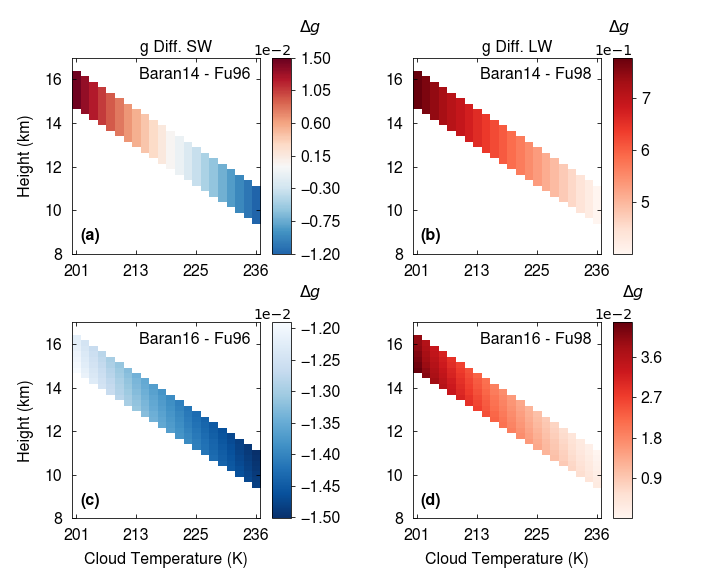

In [51]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -0.012
        vmaxi_sw   = 0.015
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = 0.4
        vmaxi_lw   = 0.8
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 5)
        cmap_lw    = 'Reds'
        norm_lw    = None
        
        labelpad   = -30
    else:
        # For SW:
        vmini_sw   = -0.015
        vmaxi_sw   = -0.012
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'Blues_r'
        norm_sw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = 0
        vmaxi_lw   = 0.045
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Reds'
        norm_lw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -30
         
    # Shortwave g Difference
    im = ax[schi, 0].imshow(g_sw_t1_bb_diff_plot[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta g$', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'g Diff. SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave g Difference
    im = ax[schi, 1].imshow(g_lw_t1_bb_diff_plot[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta g$', labelpad = labelpad, y = 1.2, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'g Diff. LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, g_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_Kext_barans_diff_SM_v2c.png', dpi=500)

### Figure with relative difference

In [52]:
# Shortwave:
g_sw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
g_sw_t1_bb_diff_plot_RD[0] = ((g_sw_t1_bb_plot[1] - g_sw_t1_bb_plot[0])/g_sw_t1_bb_plot[0])*100
# Baran2016 - Fu
g_sw_t1_bb_diff_plot_RD[1] = ((g_sw_t1_bb_plot[2] - g_sw_t1_bb_plot[0])/g_sw_t1_bb_plot[0])*100

# Longwave:
g_lw_t1_bb_diff_plot_RD    = np.zeros((2, profi, tempi))
# Baran2014 - Fu
g_lw_t1_bb_diff_plot_RD[0] = ((g_lw_t1_bb_plot[1] - g_lw_t1_bb_plot[0])/g_lw_t1_bb_plot[0])*100
# Baran2016 - Fu
g_lw_t1_bb_diff_plot_RD[1] = ((g_lw_t1_bb_plot[2] - g_lw_t1_bb_plot[0])/g_lw_t1_bb_plot[0])*100

/tmp/ipykernel_18978/3230592633.py:4: RuntimeWarning: invalid value encountered in divide
  g_sw_t1_bb_diff_plot_RD[0] = ((g_sw_t1_bb_plot[1] - g_sw_t1_bb_plot[0])/g_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/3230592633.py:6: RuntimeWarning: invalid value encountered in divide
  g_sw_t1_bb_diff_plot_RD[1] = ((g_sw_t1_bb_plot[2] - g_sw_t1_bb_plot[0])/g_sw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/3230592633.py:11: RuntimeWarning: invalid value encountered in divide
  g_lw_t1_bb_diff_plot_RD[0] = ((g_lw_t1_bb_plot[1] - g_lw_t1_bb_plot[0])/g_lw_t1_bb_plot[0])*100
/tmp/ipykernel_18978/3230592633.py:13: RuntimeWarning: invalid value encountered in divide
  g_lw_t1_bb_diff_plot_RD[1] = ((g_lw_t1_bb_plot[2] - g_lw_t1_bb_plot[0])/g_lw_t1_bb_plot[0])*100


In [53]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
b14_fu_max_sw = np.nanmax(g_sw_t1_bb_diff_plot_RD[0][np.nonzero(g_sw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_sw)
b14_fu_min_sw = np.nanmin(g_sw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_sw)
b16_fu_max_sw = np.nanmax(g_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu max: ', b16_fu_max_sw)
b16_fu_min_sw = np.nanmin(g_sw_t1_bb_diff_plot_RD[1])
print('Baran2016 - Fu min: ', b16_fu_min_sw)

print('')
# Longwave g differences:
print('Longwave CRH Differences:')
b14_fu_max_lw = np.nanmax(g_lw_t1_bb_diff_plot_RD[0][np.nonzero(g_lw_t1_bb_diff_plot_RD[0])])
print('Baran2014 - Fu max: ', b14_fu_max_lw)
b14_fu_min_lw = np.nanmin(g_lw_t1_bb_diff_plot_RD[0])
print('Baran2014 - Fu min: ', b14_fu_min_lw)
b16_fu_max_lw = np.nanmax(g_lw_t1_bb_diff_plot_RD[1][np.nonzero(g_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu max: ', b16_fu_max_lw)
b16_fu_min_lw = np.nanmin(g_lw_t1_bb_diff_plot_RD[1][np.nonzero(g_lw_t1_bb_diff_plot_RD[1])])
print('Baran2016 - Fu min: ', b16_fu_min_lw)

Shortwave CRH Differences:
Baran2014 - Fu max:  0.46983857709313614
Baran2014 - Fu min:  -0.38827875348283636
Baran2016 - Fu max:  -0.3843675014079134
Baran2016 - Fu min:  -0.484893064952399

Longwave CRH Differences:
Baran2014 - Fu max:  3.4516341974708187
Baran2014 - Fu min:  1.7804067078574883
Baran2016 - Fu max:  0.19341884812828813
Baran2016 - Fu min:  0.0004207893301168088


<IPython.core.display.Javascript object>


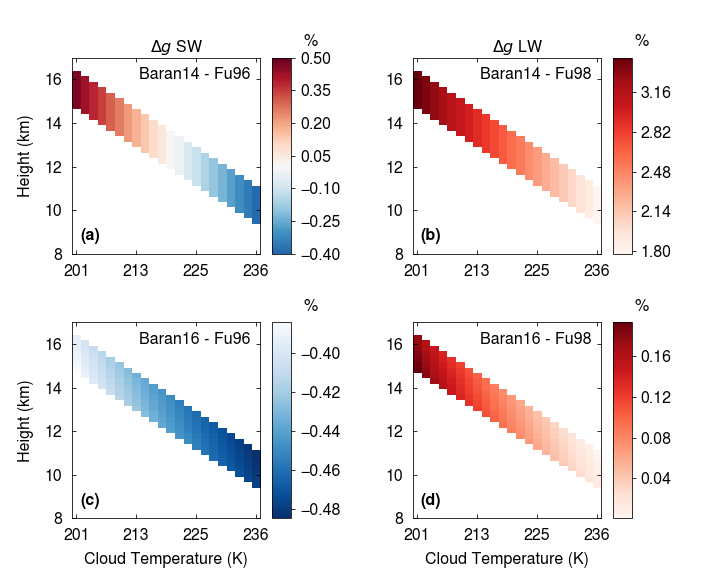

In [54]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 8 # inches
flength  = 10 # inches

rows    = 2
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.9, bottom = 0.1, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for schi in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    if schi == 0:
        # For SW:
        vmini_sw   = -0.4
        vmaxi_sw   = 0.5
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 7)
        cmap_sw    = 'RdBu_r'
        norm_sw    = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)
        
        #For LW:
        vmini_lw   = 1.8
        vmaxi_lw   = 3.5
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Reds'
        norm_lw    = None
        
        labelpad   = -30
    else:
        # For SW:
        vmini_sw   = -0.48
        vmaxi_sw   = -0.38
        tickbar_sw = np.linspace(vmini_sw, vmaxi_sw, 6)
        cmap_sw    = 'Blues_r'
        norm_sw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)#colors.PowerNorm(gamma = 0.01)
        
        #For LW:
        vmini_lw   = 0
        vmaxi_lw   = 0.2
        tickbar_lw = np.linspace(vmini_lw, vmaxi_lw, 6)
        cmap_lw    = 'Reds'
        norm_lw    = None #MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw)#colors.PowerNorm(gamma = 0.01)
        
        labelpad   = -30
         
    # Shortwave g Difference
    im = ax[schi, 0].imshow(g_sw_t1_bb_diff_plot_RD[schi], cmap = cmap_sw, aspect = 'auto',
                            norm = norm_sw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 0].set_title(r'$\Delta g$ SW', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave g Difference
    im = ax[schi, 1].imshow(g_lw_t1_bb_diff_plot_RD[schi], cmap = cmap_lw, aspect = 'auto', 
                            norm = norm_lw)
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label('%', labelpad = labelpad, y = 1.12, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    #cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if schi == 0:
        ax[schi, 1].set_title(r'$\Delta g$ LW', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, g_sw_t1_bb.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 1:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 0.05, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_g_barans_Rdiff_SM_v2c.png', dpi=500)

Saving colorbar characteristics per scheme (tickbars, cmap, norm):

In [55]:
g_sw_t1_bb_RD_colorbar = [[np.linspace(-0.4, 0.5, 7), 'RdBu_r', MidpointNormalize(midpoint = 0, vmin = -0.4, vmax = 0.5)],
                          [np.linspace(-0.48, -0.38, 6), 'Blues_r', None]]
g_lw_t1_bb_RD_colorbar = [[np.linspace(1.8, 3.5, 6), 'Reds', None],
                          [np.linspace(0, 0.2, 6), 'Reds', None]]

## Figure S05

<IPython.core.display.Javascript object>


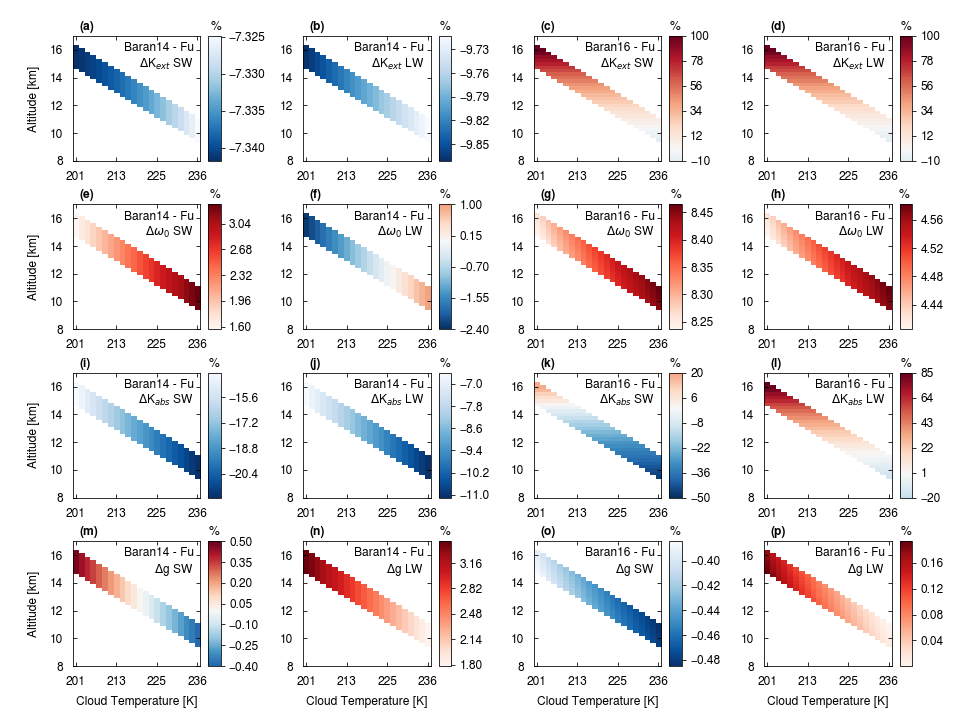

In [56]:
fontname = 'Nimbus Sans' # Arial
fontsize = 12
fheigth  = 10 # inches
flength  = 13.5 # inches

rows    = 4
columns = 4
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.075, left = 0.075, right = 0.95, 
                    hspace = .35, wspace = .45)

opt_props = ['K_ext', 'ssa', 'K_abs', 'g']
rad_comps = ['sw', 'lw']
diff_props_label = [r'$\Delta$K$_{ext}$', r'$\Delta\omega_0$', r'$\Delta$K$_{abs}$', r'$\Delta$g']
rad_label        = ['SW', 'LW']

Diff          = ['Baran14 - Fu', 'Baran16 - Fu']
panel_letters = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)',
                 '(i)','(j)','(k)','(l)','(m)','(n)','(o)','(p)']
labelpadi     = [-50,-45,-35,-35,
                 -37.5,-45,-37.5,-40,
                 -45,-45,-35,-35,
                 -45,-37.5,-45,-37.5]

panel_i = 0
# COLORMAPS
for row in range(rows):
    for col in range(columns):
        if col == 0: radi = 0; schi = 0
        if col == 1: radi = 1; schi = 0
        if col == 2: radi = 0; schi = 1
        if col == 3: radi = 1; schi = 1
        to_plot     = eval(opt_props[row] + '_' + rad_comps[radi] + '_t1_bb_diff_plot_RD')[schi]
        colobar_set = eval(opt_props[row] + '_' + rad_comps[radi] + '_t1_bb_RD_colorbar')[schi]

        im = ax[row, col].imshow(to_plot, cmap = colobar_set[1], aspect = 'auto',
                                 norm = colobar_set[2])
        cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = colobar_set[0])
        cbar.set_label('%', labelpad = labelpadi[panel_i], y = 1.12, rotation=0, 
                       fontsize = fontsize, fontname = fontname)
        cbar.ax.tick_params(labelsize = fontsize, pad = 5)
        #if schi == 0: cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize-2)
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontname(fontname)
            
#         ax[row, col].set_title(diff_props_label[row] + ' ' + rad_label[radi], 
#                                color = 'black', x = 0.555, y = 1,
#                                fontsize = fontsize, fontname = fontname)
        
        if row == 3:
            ax[row,col].set_xlabel(r'Cloud Temperature [K]', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[row, col].tick_params(axis = 'x', which = 'major', color = 'black',
                                 size = 4, direction = 'in', top = True,
                                 labelsize = fontsize, pad = 10)
        for tick in ax[row, col].get_xticklabels():
            tick.set_fontname(fontname)
            
        # AXIS PARAMETERS
        # Y Axis
        yticks      = np.arange(0, eval(opt_props[row] + '_' + rad_comps[radi] + '_t1_bb').shape[2]+1, 8) # altitude tick labels
        # height tickLabels are rounded for visualization:
        yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()

        # X Axis:
        xticks      = np.arange(0, 28, 7) # 21 elements max
        xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
        ax[row, col].set_xticks(xticks)
        ax[row, col].set_xticklabels(xticklabels) #[::-1]
        ax[row, col].tick_params(axis = 'y', which = 'major', color = 'black',
                                 size = 4, direction = 'in', right = True,
                                 labelsize = fontsize, pad = 10)
        for tick in ax[row, col].get_yticklabels():
            tick.set_fontname(fontname)
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(yticklabels)
        if col == 0:
            ax[row, col].set_ylabel('Altitude [km]', fontsize = fontsize, fontname = fontname,
                                    color ='black', labelpad = 10)
        ax[row, col].text(0.95, 0.95, Diff[schi] + '\n' + diff_props_label[row] + ' ' + rad_label[radi],
                          ha = 'right', va = 'top', transform = ax[row, col].transAxes,
                          fontsize = fontsize, fontname = fontname, color = 'black')
        ax[row, col].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[row, col].text(0.05, 1.025, panel_letters[panel_i], weight = 'bold',
                         ha = 'left', va = 'bottom', transform = ax[row, col].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/1D_ecrad_analysis/paper_figures/')
#plt.savefig(out_dir + 'fs05.pdf', dpi = 300)